In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from utils.cub_config import Config

# se você estiver usando CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
'''Convolutional Block Attention Module (CBAM)
'''

import torch
import torch.nn as nn
from torch.nn.modules import pooling
from torch.nn.modules.flatten import Flatten



class Channel_Attention(nn.Module):
    '''Channel Attention in CBAM.
    '''

    def __init__(self, channel_in, reduction_ratio=16, pool_types=['avg', 'max']):
        '''Param init and architecture building.
        '''

        super(Channel_Attention, self).__init__()
        self.pool_types = pool_types

        self.shared_mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=channel_in, out_features=channel_in//reduction_ratio),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=channel_in//reduction_ratio, out_features=channel_in)
        )


    def forward(self, x):
        b, c, h, w = x.size()
    
        # média global
        avg_pool = torch.mean(x, dim=(2, 3), keepdim=True)
    
        # máximo global (reduzindo um eixo por vez)
        max_pool, _ = torch.max(x, dim=2, keepdim=True)
        max_pool, _ = torch.max(max_pool, dim=3, keepdim=True)
    
        # flatten e passa pelo MLP
        avg_out = self.shared_mlp(avg_pool.view(b, c))
        max_out = self.shared_mlp(max_pool.view(b, c))
    
        out = avg_out + max_out
        scale = torch.sigmoid(out).view(b, c, 1, 1)
    
        return x * scale


class ChannelPool(nn.Module):
    '''Merge all the channels in a feature map into two separate channels where the first channel is produced by taking the max values from all channels, while the
       second one is produced by taking the mean from every channel.
    '''
    def forward(self, x):
        return torch.cat((torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1)


class Spatial_Attention(nn.Module):
    '''Spatial Attention in CBAM.
    '''

    def __init__(self, kernel_size=7):
        '''Spatial Attention Architecture.
        '''

        super(Spatial_Attention, self).__init__()

        self.compress = ChannelPool()
        self.spatial_attention = nn.Conv2d(in_channels=2, out_channels=1, kernel_size=kernel_size, stride=1, dilation=1, padding=(kernel_size-1)//2, bias=False)
            
       


    def forward(self, x):
        '''Forward Propagation.
        '''
        x_compress = self.compress(x)
        x_output = self.spatial_attention(x_compress)
        scaled = torch.sigmoid(x_output)
        return x * scaled


class CBAM(nn.Module):
    '''CBAM architecture.
    '''
    def __init__(self, channel_in, reduction_ratio=16, pool_types=['avg', 'max'], spatial=True):
        '''Param init and arch build.
        '''
        super(CBAM, self).__init__()
        self.spatial = spatial

        self.channel_attention = Channel_Attention(channel_in=channel_in, reduction_ratio=reduction_ratio, pool_types=pool_types)

        if self.spatial:
            self.spatial_attention = Spatial_Attention(kernel_size=7)


    def forward(self, x):
        '''Forward Propagation.
        '''
        x_out = self.channel_attention(x)
        if self.spatial:
            x_out = self.spatial_attention(x_out)

        return x_out

In [3]:
from torchvision.models.resnet import Bottleneck
from torchvision.models import resnet50

class ResNet50_CBAM(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        # Carrega o modelo base
        self.base = resnet50(weights="IMAGENET1K_V1")
        
        # Congela as primeiras camadas (opcional, pode descongelar depois)
        for param in list(self.base.parameters())[:100]:
            param.requires_grad = False
        
        # Adiciona CBAM após as camadas 3 e 4
        self.cbam3 = CBAM(channel_in=1024)
        self.cbam4 = CBAM(channel_in=2048)
        
        # Substitui a última camada totalmente conectada
        self.base.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        # Camadas originais até layer3
        x = self.base.conv1(x)
        x = self.base.bn1(x)
        x = self.base.relu(x)
        x = self.base.maxpool(x)

        x = self.base.layer1(x)
        x = self.base.layer2(x)
        x = self.base.layer3(x)
        x = self.cbam3(x)  # CBAM aqui
        x = self.base.layer4(x)
        x_conv = self.cbam4(x)  # salvar as features com atenção

        x = self.base.avgpool(x_conv)
        x = torch.flatten(x, 1)
        x = self.base.fc(x)
        return x_conv,x

In [6]:
path_modelo = Config.MODEL_CBAM

model = ResNet50_CBAM(num_classes=200)
model.load_state_dict(torch.load(path_modelo, map_location=device, weights_only=True))
model = model.to(device)
model.eval()

ResNet50_CBAM(
  (base): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

In [7]:
img_path = "../data/CUB-200-2011/images/test/027.Shiny_Cowbird/Shiny_Cowbird_0015_796858.jpg"

transform = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

image = Image.open(img_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)

In [9]:
# Dicionário para armazenar as ativações
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Registra o hook na atenção espacial da última CBAM
model.cbam4.spatial_attention.register_forward_hook(get_activation('spatial_attn'))

In [10]:
with torch.no_grad():
    x_conv, output = model(input_tensor)
    probs = torch.softmax(output, dim=1)
    pred_class = torch.argmax(probs, dim=1).item()

print(f"Classe predita: {pred_class}")


Classe predita: 29


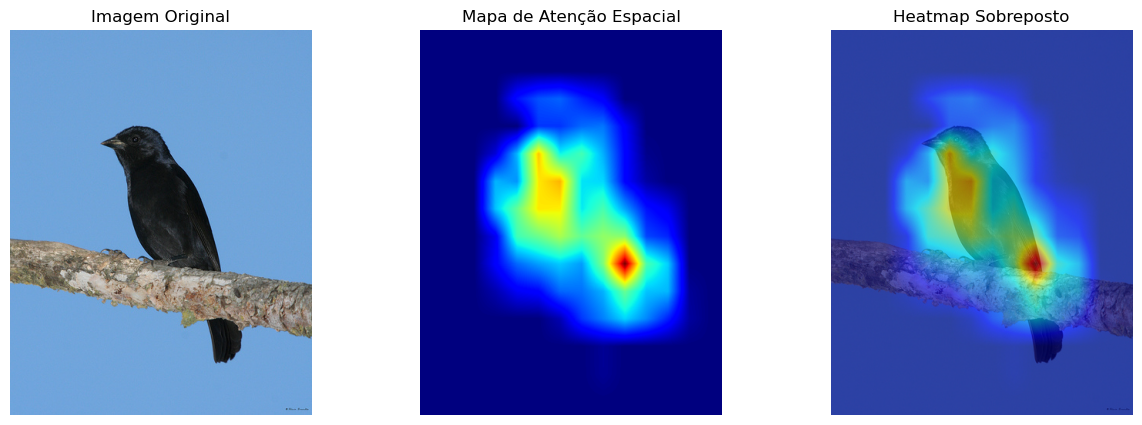

In [ ]:

attn_map = activation['spatial_attn'][0, 0].cpu().numpy()
attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())


attn_map_resized = cv2.resize(attn_map, (image.width, image.height))

heatmap = cv2.applyColorMap(np.uint8(255 * attn_map_resized), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)


img_np = np.array(image)
superimposed = np.uint8(0.6 * heatmap + 0.4 * img_np)


plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Imagem Original")
plt.imshow(img_np)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Mapa de Atenção Espacial")
plt.imshow(attn_map_resized, cmap='jet')
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Heatmap Sobreposto")
plt.imshow(superimposed)
plt.axis("off")
plt.show()